# Computer Vision CSCI-GA.2272-001 Assignment 1, part 2.

Fall 2021 semester.

Due date: **September 30th 2021.**

## Introduction
This assignment requires you to participate in a Kaggle competition with the rest of the class on the The German Traffic Sign Recognition Benchmark [http://benchmark.ini.rub.de/?section=gtsrb&subsection=news]. The objective is to produce a model that gives the highest possible accuracy on the test portion of this dataset. You can register for the competition using the private link: https://www.kaggle.com/c/nyu-computer-vision-csci-ga2271-2021/overview.

Skeleton code is provided in the colab below. This contains code for training a simple default model and evaluating it on the test set. The evaluation script produces a file gtsrb_kaggle.csv that lists the IDs of the test set images, along with their predicted label. This file should be uploaded to the Kaggle webpage, which will then produce a test accuracy score. 

Your goal is to implement a new model architecture that improves upon the baseline performance. You are free to implement any approach covered in class or from research papers. This part will count for 50% of the overall grade for assignment 1. This Grading will depend on your Kaggle performance and rank, as well as novelty of the architecture.  

## Rules
You should make a copy of this Colab (File->Save a copy in Drive). Please start the assignment early and don’t be afraid to ask for help from either the TAs or myself. You are allowed to collaborate with other students in terms discussing ideas and possible solutions. However you code up the solution yourself, i.e. you must write your own code. Copying your friends code and just changing all the names of the variables is not allowed! You are not allowed to use solutions from similar assignments in courses from other institutions, or those found elsewhere on the web.
Your solutions should be submitted via the Brightspace system. This should include a brief description (in the Colab) explaining the model architectures you explored, citing any relevant papers or techniques that you used. You should also include convergence plots of training accuracy vs epoch for relevant models. 

### Important Details
• You are only allowed eight (8) submissions to the Kaggle evaluation server per day. This is to prevent over-fitting on the test dataset. So be sure to start the assignment early!

• You are NOT ALLOWED to use the test set labels during training in any way. Doing so will be regarded as cheating and penalized accordingly.

• The evaluation metric is accuracy, i.e. the fraction of test set examples where the predicted label agrees with the ground truth label.

• You should be able to achieve a test accuracy of at least 0.95. 

• *Extra important:* Please use your NYU NetID as your Kaggle username, so the TAs can figure out which user you are on the leaderboard. 


= = = = = = = = = = = = = = = = = = = = \
**Name:** Haoming(Hammond) Liu\
**NetID:** hl3797 \
= = = = = = = = = = = = = = = = = = = = \\

**Note:** Please remember to change the dataset dir before running. Have a good day! :p

# Dataset Preparation


1.  Download `dataset.zip` from to your local machine.
2.  Unzip the file. You should see a `dataset` directory with three subfolders (`training,validation,testing`). 
3.  Go to Google Drive (on your NYU account) and make a directory `assign2_dataset` (New button --> New Folder).
4.  Upload each of the three subfolders to it (New button --> Folder upload). 
5.  Run the code block below. It will ask for permission to mount your Google Drive (NYU account) so this colab can access it. Paste the authorization code into the box as requested. 


In [ ]:
# Load the Drive helper and mount
import os
from google.colab import drive
drive.mount('/content/drive')
# FIRST OF ALL, PLEASE CHANGE THE DIR HERE AS NEEDED
os.chdir('/content/drive/MyDrive/Colab Notebooks/datasets/GTSRB')
sorted(os.listdir('./'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['1632147620',
 '1632160827',
 '1632266735',
 '1632268605',
 '1632271525',
 '1632272883',
 '1632278568',
 '1632319899',
 '1632440682',
 '1632442228',
 'ensemble',
 'other',
 'testing',
 'train',
 'validation']

# Dataloader

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import random
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, X_path="X.pt", y_path="y.pt", aug=False):
        self.aug = aug
        self.X = torch.load(X_path).squeeze(1)
        self.y = torch.load(y_path).squeeze(1)
            
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        if self.aug and (random.random() > 0.3):
            x, y = self.X[idx], self.y[idx]
            x = transforms.RandomRotation(5)(x)
            return x, y
        else:
            return self.X[idx], self.y[idx]

def get_dataloaders(batch_size, aug=False):
    train_set = MyDataset(X_path='train/X.pt', y_path='train/y.pt')
    val_set = MyDataset(X_path='validation/X.pt', y_path='validation/y.pt')
    train_loader = DataLoader(
        dataset=train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        pin_memory=True,
        drop_last=True
    )
    val_loader = DataLoader(
        dataset=val_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=1,
        pin_memory=True,
    )
    train_loader_aug = None
    if aug:
        train_set_aug = MyDataset(X_path='train/X.pt', y_path='train/y.pt', aug=True)
        train_loader_aug = DataLoader(
            dataset=train_set_aug,
            batch_size=batch_size,
            shuffle=True,
            num_workers=1,
            pin_memory=True,
            droplast=True
        )
    return train_loader, val_loader, train_loader_aug

[batch size]: 32
[iter num]: 1104
[iter size]: torch.Size([32, 3, 32, 32])
[data size]: 35339


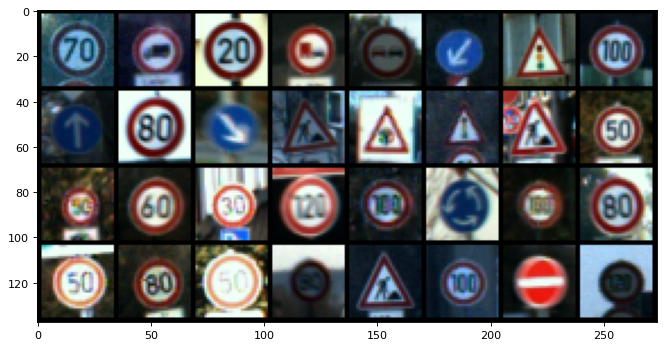

tensor([[ 4, 16,  0, 10,  9, 39, 26,  7],
        [35,  5, 38, 25, 30, 26, 25,  2],
        [ 2,  3,  1,  8,  7, 40,  7,  5],
        [ 2,  5,  2,  5, 25,  7, 17,  8]])


In [ ]:
# Plot some images from the dataset

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

train_loader = get_dataloaders(batch_size=32)[0]
dataiter = iter(train_loader)
images, labels = dataiter.next()

print('[batch size]:', len(images))
print('[iter num]:', len(train_loader))
print('[iter size]:', images.size())
print('[data size]:', len(train_loader.dataset))

grid = make_grid(images, nrow=8, normalize=True, scale_each=True)
plt.figure(figsize=(10, 6), dpi=80)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

print(labels.reshape(4, 8))

**Code Citation** \\
The `Poly_LR_Scheduler` class is implemented based on the `LR_Scheduler` class in this [repo](https://github.com/junfu1115/DANet/blob/master/encoding/utils/lr_scheduler.py).

In [ ]:
class Poly_LR_Scheduler(object):
    def __init__(self, base_lr, num_epochs, iters_per_epoch, base_poly=0.9, quiet=False):
        self.epoch = -1
        self.quiet = quiet
        self.base_lr = base_lr
        self.base_poly = base_poly
        self.iters_per_epoch = iters_per_epoch
        self.total_iters = num_epochs * iters_per_epoch

    def __call__(self, optimizer, i, epoch, best_pred):
        T = epoch * self.iters_per_epoch + i
        lr = self.base_lr * pow((1 - 1.0 * T / self.total_iters), self.base_poly)
        if (not self.quiet) and (epoch != self.epoch):
            self.epoch = epoch
            print('=> Epoch %i, lr = %.4f, best_pred = %.2f%s' % (epoch+1, lr, best_pred, '%'))
        assert lr >= 0
        self._adjust_learning_rate(optimizer, lr)

    def _adjust_learning_rate(self, optimizer, lr):
        for i in range(len(optimizer.param_groups)):
            optimizer.param_groups[i]['lr'] = lr

# Training & Model
**Note:** I rewrite the start code quite a bit, which undoubtedly makes my life easier during the training prodecure. The implementation of the `trainer` class is mainly based on [my own Github repo](https://github.com/hmdliu/PyTorch-CNN-Codebase).

In [ ]:
class Trainer():
    def __init__(self, config):
        self.config = config
        
        # init trainer
        self.best_pred = 0.0
        self.best_weights = []
        self.train_log = {
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': []
        }
        self.start_time = time.time()
        if not os.path.isdir('./%d' % self.start_time):
            os.mkdir('./%d' % self.start_time)
        torch.manual_seed(self.config['seed'])

        # init dataloader
        data_loaders = get_dataloaders(
            batch_size=self.config['batch_size'],
            aug=self.config['aug']
        )
        self.train_loader, self.val_loader, self.train_loader_aug = data_loaders
        self.train_log_interval = len(self.train_loader) // 4
    
        # init model
        self.use_cuda = (self.config['use_cuda'] and torch.cuda.is_available())
        self.device = torch.device("cuda:0" if self.config['use_cuda'] else "cpu")
        self.model = get_model(self.config['model']).to(self.device)
        print(self.model)
        if self.config['resume']['flag']:
            self.config['optim']['lr'] = self.config['resume']['lr']
            self.model.load_state_dict(torch.load(self.config['resume']['weights']))
            print('[Resume]: %s state dict loaded.' % self.config['resume']['weights'])

        # init optim & scheduler
        if self.config['optim']['method'] == 'sgd':
            self.optimizer = optim.SGD(
                params=self.model.parameters(),
                lr=self.config['optim']['lr'],
                momentum=self.config['optim']['momentum']
            )
        else:
            self.optimizer = optim.Adam(
                params=self.model.parameters(),
                lr=self.config['optim']['lr']
            )
        self.scheduler = Poly_LR_Scheduler(
            base_lr=self.config['optim']['lr'],
            base_poly=self.config['poly'],
            num_epochs=self.config['epochs'],
            iters_per_epoch=len(self.train_loader),
        )
        print(self.optimizer)

    def train_one_epoch(self, epoch):
        self.model.train()
        self.curr_epoch = epoch + 1
        self.curr_stage = self.curr_epoch / self.config['epochs']
        dataloader = self.train_loader_aug if self.config['aug'] else self.train_loader
        for batch_idx, (data, target) in enumerate(dataloader):
            if self.use_cuda:
                data, target = data.to(self.device), target.to(self.device)
            self.scheduler(self.optimizer, batch_idx, epoch, self.best_pred)
            self.optimizer.zero_grad()
            output = self.model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            self.optimizer.step()
            if batch_idx % self.train_log_interval == 0:
                print('Train Step: [%5d/%5d (%3.0f%s)], Loss: %.6f' %(
                    batch_idx * self.config['batch_size'], len(dataloader.dataset),
                    100.0 * batch_idx / len(dataloader), '%', loss.item()
                ))
                # Track the accuracy more frequently during the last 10% epochs
                if (self.curr_stage >= 0.9) and ((batch_idx+1) < len(dataloader)):
                    self.check_accuracy()
        self.check_accuracy(track_log=True)

    def eval(self, data_loader):
        self.model.eval()
        loss, correct = 0, 0
        for data, target in data_loader:
            if self.use_cuda:
                data, target = data.to(self.device), target.to(self.device)
            output = self.model(data)
            loss += F.nll_loss(output, target, reduction="sum").item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        accuracy = 100. * correct / len(data_loader.dataset)
        loss /= len(data_loader.dataset)
        return accuracy, loss
    
    def check_accuracy(self, track_log=False):
        if (not self.config['aac']) and (not track_log):
            return
        train_acc, train_loss = self.eval(self.train_loader)
        val_acc, val_loss = self.eval(self.val_loader)
        print('Train Accuracy: %.2f%s\tTrain Loss: %.6f' % (train_acc, '%', train_loss))
        print('Val Accuracy:   %.2f%s\tVal Loss:   %.6f' % (val_acc, '%', val_loss))
        if track_log:
            self.train_log['train_loss'].append(train_loss)
            self.train_log['train_acc'].append(train_acc)
            self.train_log['val_loss'].append(val_loss)
            self.train_log['val_acc'].append(val_acc)
        if val_acc > self.best_pred:
            self.best_pred = val_acc    
        if val_acc > self.config['export_bound']:
            self.export_weights(val_acc)
        print('==================================================')
    
    def export_weights(self, accuracy):
        curr_info = '%02d_%.2f' % (self.curr_epoch, accuracy)
        self.best_weights.append({
            'info': curr_info,
            'accuracy': accuracy,
            'weights': self.model.state_dict()
        })
        weight_path = os.path.join('%d' % self.start_time, 'weights_%s.pth' % curr_info)
        torch.save(self.model.state_dict(), weight_path)
        print('[Weights]: [%s] state dict exported.' % (curr_info))

    def train(self):
        for epoch in range(self.config['epochs']):
            print('\n============ train epoch [%2d/%2d] =================' % (epoch+1, self.config['epochs']))
            self.train_one_epoch(epoch)
        runtime = int(time.time() - self.start_time) / 60
        print('\n[Time]: %.2fmins\n[Best Pred]: %.2f%s' % (runtime, self.best_pred, '%'))
    
    def plot_log(self):
        assert len(self.train_log['train_loss'])
        epoch_list = list(range(len(self.train_log['train_loss'])))
        plt.figure(figsize=(12, 4), dpi=100)
        # loss figure
        plt.subplot(1, 2, 1)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.plot(epoch_list, self.train_log['train_loss'], label='train')
        plt.plot(epoch_list, self.train_log['val_loss'], label='validation')
        plt.legend()
        # accuracy figure
        plt.subplot(1, 2, 2)
        plt.xlabel('epochs')
        plt.ylabel('accuracy')
        plt.plot(epoch_list, self.train_log['train_acc'], label='train')
        plt.plot(epoch_list, self.train_log['val_acc'], label='validation')
        plt.legend()
        plt.show()



### Paper Citation
1. [MobileNetV2: Inverted Residuals and Linear Bottlenecks](https://arxiv.org/abs/1801.04381) (Sandler *et al.* 2019)
2. [Searching for MobileNetV3](https://arxiv.org/abs/1905.02244) (Howard *et al.* 2019)
3. [SimAM: A Simple, Parameter-Free Attention Module for Convolutional Neural Networks](https://proceedings.mlr.press/v139/yang21o.html) (Yang *et al.* *2021*)

### Model Exploration & Novelty

1. My core pursuit throughout this assignment is to **achieve a high test accuracy with the least amount of params**. Hence, the first version of my model uses the building block of MobileNetV2 -- **Inverted Residual Block** that adopts depth-separable convolution. Such a design uses the parameters in a more efficient way, so I replace all the ConvBnAct units by the IRB blocks.
2. The first conv block uses 5x5 kernels to get a **larger reception field**, and used the **Hardswish non-linearity** (from the MobileNetV3 paper) here (and in the mlp classifier as well). The Hardswish activation is a good choice between linear functions and ReLU, and it replaced the computationally-expensive sigmoid funtion in the Swish non-linearity.
3. Overall, the channel num of conv unis follows the **pyramid design**. The small version originally uses (16, 64, 128) channels, and later reduced to (16, 48, 128) without significant impact on the accuracy. To gain more power for prediction, I enlarged the number of channels in the large version, which is (64, 128, 256). Besides, **BatchNorm** and **Dropout** are applied in the network so as to speed up training and get more robust features.
4. To further refine the feature map, I applied the newly-proposed **SimAM Block**, which is a novel **parameter-free 3D attention module** (inspired by some biological facts). By the experiments, this module can significantly improve the prediction accuracy and speed up the convergence to some extent.
5. Based on extensive experiments, I found that using pooling too frequently ususally results in a loss of features, and may thus make the attention module useless. Hence, the final models **preserve the feature map size** to be relatively large, which enables us to **exploit full potentials of the attetion module**. Finally, the AdaptiveMaxPool layer at the end of the conv unit can help us control the feature num feeding to the FC unit. I tried 1x1, 2x2, and 4x4 for the final pooling layer, and 2x2 seems to be the best choice.
6. Instead of a vanilla classifier, the final FC unit uses a 2-layer MLP with Hardswish non-linearity, BatchNorm, and Dropout. This reduces the possibility of overfitting, and contributes a consistent improvement on the val & test accuracy.
7. I use Adam optimizer with polynomial lr scheduler throughout the training, and it's better than the original setting in the start code.
8. I tried to augment the data by random rotation (and brightness adjustment), but there wasn't a significant improvement for my case. 
9. At the end, the test accuracy of each version are as follow. Small version: >99.0%; Large version: >99.4%; Ensemble version: >99.6%.


In [ ]:
# Simple Net (from start code)
class Net(nn.Module):
    def __init__(self, num_classes=43):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, num_classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x,dim=1)

# Inverted Residual Block (Mobile Net v2)
class IRB_Block(nn.Module):
    def __init__(self, in_feats, out_feats, pool=True, expand_ratio=6):
        super().__init__()
        mid_feats = round(in_feats * expand_ratio)
        self.pool = pool
        self.irb_unit = nn.Sequential(
            # point-wise conv
            nn.Conv2d(in_feats, mid_feats, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(mid_feats),
            nn.ReLU6(inplace=True),
            # depth-wise conv
            nn.Conv2d(mid_feats, mid_feats, kernel_size=3, stride=1, padding=1, groups=mid_feats, bias=False),
            nn.BatchNorm2d(mid_feats),
            nn.ReLU6(inplace=True),
            # point-wise conv
            nn.Conv2d(mid_feats, out_feats, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_feats),
        )

    def forward(self, x):
        return F.max_pool2d(self.irb_unit(x), 2) if self.pool else self.irb_unit(x)

# SimAM Block (Parameter-free 3D Attention)
class SimAM_Block(torch.nn.Module):
    def __init__(self, in_feats, lamb=1e-4):
        super().__init__()
        self.act = nn.Sigmoid()
        self.lamb = lamb

    def forward(self, x):
        _, _, h, w = x.size()
        n = w * h - 1
        x_minus_mu_square = (x - x.mean(dim=[2,3], keepdim=True)).pow(2)
        y = x_minus_mu_square / (4 * (x_minus_mu_square.sum(dim=[2,3], keepdim=True) / n + self.lamb)) + 0.5
        return x * self.act(y)

# Large version
class HMDNetPro(nn.Module):
    def __init__(self, num_classes=43):
        super(HMDNetPro, self).__init__()

        self.conv_unit = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.Hardswish(),
            IRB_Block( 64,  64, pool=True),
            IRB_Block( 64, 128, pool=False),
            IRB_Block(128, 256, pool=False),
            SimAM_Block(256),
            nn.AdaptiveMaxPool2d(2),
            nn.BatchNorm2d(256),
            nn.Dropout2d(p=0.5),
        )
        
        self.fc_unit = nn.Sequential(
            nn.Linear(1024, 64),
            nn.BatchNorm1d(64),
            nn.Hardswish(),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes),
            nn.BatchNorm1d(num_classes),
        )

    def forward(self, x):
        b, _, _, _ = x.size()
        x = self.conv_unit(x).view(b, -1)
        x = self.fc_unit(x)
        return F.log_softmax(x, dim=1)

# Small version
class HMDNet(nn.Module):
    def __init__(self, num_classes=43):
        super(HMDNet, self).__init__()

        self.conv_unit = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(16),
            nn.Hardswish(),
            IRB_Block(16, 48, pool=True),
            IRB_Block(48, 128, pool=False),
            SimAM_Block(128),
            nn.AdaptiveMaxPool2d(2),
            nn.BatchNorm2d(128),
            nn.Dropout2d(p=0.5),
        )
        
        self.fc_unit = nn.Sequential(
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Hardswish(),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes),
            nn.BatchNorm1d(num_classes),
        )

    def forward(self, x):
        b, _, _, _ = x.size()
        x = self.conv_unit(x).view(b, -1)
        x = self.fc_unit(x)
        return F.log_softmax(x, dim=1)

def get_model(model_name):
    avail_models = {
        'net': Net,
        'hmd': HMDNet,
        'hmdp': HMDNetPro
    }
    return avail_models[model_name](num_classes=43)

In [ ]:
# Training is based on a config dict

config = {
    'seed': 1,
    'aug': False,
    'model': 'hmdp',
    'use_cuda': True,
    'batch_size': 32,
    'epochs': 30,
    'poly': 0.9,
    # 'optim': {
    #     'method': 'sgd',
    #     'lr': 0.03,
    #     'momentum': 0.9,
    # }
    'optim': {
        'method': 'adam',
        'lr': 0.001,
    },
    'resume': {
        'flag': False,
        # 'lr': 0.0003,
        # 'weights': './path/weights.pth',
    },
    'aac': False,           # additional accuracy check
    'export_bound': 99.5    # export weightd as needed
}

trainer = Trainer(config)
trainer.train()

HMDNetPro(
  (conv_unit): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Hardswish()
    (3): IRB_Block(
      (irb_unit): Sequential(
        (0): Conv2d(64, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=False)
        (4): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU6(inplace=True)
        (6): Conv2d(384, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): IRB_Block(
      (irb_unit): Sequential(
        (0): Conv2d(64, 384, kernel_size=(1, 1),

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Step: [ 8832/35339 ( 25%)], Loss: 1.927716
Train Step: [17664/35339 ( 50%)], Loss: 0.943927
Train Step: [26496/35339 ( 75%)], Loss: 0.967804
Train Accuracy: 97.33%	Train Loss: 0.313779
Val Accuracy:   83.59%	Val Loss:   0.905549

============ train epoch [ 2/30] =================
=> Epoch 2, lr = 0.0010, best_pred = 83.59%
Train Step: [    0/35339 (  0%)], Loss: 0.752357
Train Step: [ 8832/35339 ( 25%)], Loss: 0.543786
Train Step: [17664/35339 ( 50%)], Loss: 0.505723
Train Step: [26496/35339 ( 75%)], Loss: 0.365627
Train Accuracy: 99.71%	Train Loss: 0.105752
Val Accuracy:   95.87%	Val Loss:   0.422624

============ train epoch [ 3/30] =================
=> Epoch 3, lr = 0.0009, best_pred = 95.87%
Train Step: [    0/35339 (  0%)], Loss: 0.469687
Train Step: [ 8832/35339 ( 25%)], Loss: 0.379166
Train Step: [17664/35339 ( 50%)], Loss: 0.469476
Train Step: [26496/35339 ( 75%)], Loss: 0.233293
Train Accuracy: 99.90%	Train Loss: 0.051557
Val Accuracy:   97.26%	Val Loss:   0.269562

====

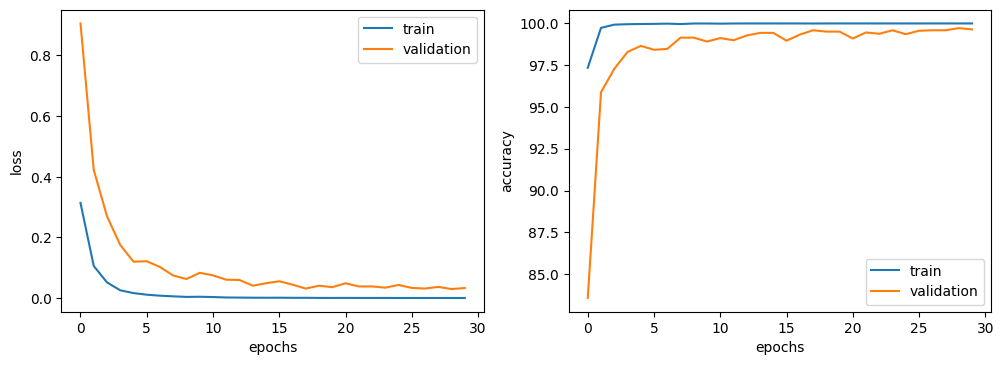

In [ ]:
# plot the training log
trainer.plot_log()

In [ ]:
# trainable parameters summary
from torchsummary import summary

# Small Version: 0.1M params (test acc: >99.0%)
print('Small Version:')
summary(HMDNet().to(trainer.device), (3, 32, 32))

# Large Version: 0.5M params (test acc: >99.4%)
print('\nLarge Version:')
summary(HMDNetPro().to(trainer.device), (3, 32, 32))

# Ensemble Version: mutiple models (test acc: >99.6%)

Small Version:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]           1,200
       BatchNorm2d-2           [-1, 16, 32, 32]              32
         Hardswish-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 96, 32, 32]           1,536
       BatchNorm2d-5           [-1, 96, 32, 32]             192
             ReLU6-6           [-1, 96, 32, 32]               0
            Conv2d-7           [-1, 96, 32, 32]             864
       BatchNorm2d-8           [-1, 96, 32, 32]             192
             ReLU6-9           [-1, 96, 32, 32]               0
           Conv2d-10           [-1, 48, 32, 32]           4,608
      BatchNorm2d-11           [-1, 48, 32, 32]              96
        IRB_Block-12           [-1, 48, 16, 16]               0
           Conv2d-13          [-1, 288, 16, 16]          13,824
      BatchNorm2d-14    

# Evaluate and Submit to Kaggle



In [ ]:
# test_set prediction for a single model

import pickle
import pandas as pd

batch_size = 32
only_best_pred = False

test_set = MyDataset(X_path='testing/test.pt', y_path='train/y.pt')
test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

test_data = torch.load('testing/test.pt')
file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

for info_dict in trainer.best_weights:

    if only_best_pred and (info_dict['accuracy'] < trainer.best_pred):
        continue

    info = info_dict['info']
    weights_path = './%d/weights_%s.pth' % (trainer.start_time, info)
    outfile = './%d/gtsrb_kaggle_%s.csv' % (trainer.start_time, info)
    output_file = open(outfile, "w")
    dataframe_dict = {"Filename" : [], "ClassId": []}

    # TODO: load your model here, don't forget to put it on Eval mode !
    network = HMDNetPro().to(trainer.device)
    network.load_state_dict(torch.load(weights_path))
    network.eval()

    for batch_idx, (data, target) in enumerate(test_loader):
        
        output = network(data.to(trainer.device))
        pred = output.data.max(1, keepdim=True)[1]
        for i in range(batch_size):
            idx = batch_idx * batch_size + i
            if idx >= len(file_ids):
                break
            file_id = file_ids[idx][0:5]
            dataframe_dict['Filename'].append(file_id)
            dataframe_dict['ClassId'].append(pred[i].item())

    df = pd.DataFrame(data=dataframe_dict)
    df.to_csv(outfile, index=False)
    print("Written to csv file {}".format(outfile))

Written to csv file ./1633033535/gtsrb_kaggle_18_99.56.csv
Written to csv file ./1633033535/gtsrb_kaggle_24_99.56.csv
Written to csv file ./1633033535/gtsrb_kaggle_26_99.53.csv
Written to csv file ./1633033535/gtsrb_kaggle_27_99.56.csv
Written to csv file ./1633033535/gtsrb_kaggle_28_99.56.csv
Written to csv file ./1633033535/gtsrb_kaggle_29_99.69.csv
Written to csv file ./1633033535/gtsrb_kaggle_30_99.61.csv


### Ensembling Method

I also tried to improve the accuracy on the test set by incorporating multiple models. The core idea is to choose the prediction with the highest confidence value among all the input models (i.e. adding a MaxOut layer). This indeed improves the accuracy a bit. On the public leaderboard, I achieved 99.683% test accuracy.

In [ ]:
# Ensembling Method

def ensemble(model_list):

    import pickle
    import pandas as pd

    batch_size = 32
    device = 'cuda:0'

    test_set = MyDataset(X_path='testing/test.pt', y_path='train/y.pt')
    test_loader = DataLoader(
        dataset=test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        pin_memory=True
    )

    test_data = torch.load('testing/test.pt')
    file_ids = pickle.load(open('testing/file_ids.pkl', 'rb'))

    outfile = './gtsrb_kaggle_ensemble_0923_06.csv'
    output_file = open(outfile, "w")
    dataframe_dict = {"Filename" : [], "ClassId": []}

    pred_dict = {}

    for weights_path in model_list:

        # load current model weights
        print('pred:', weights_path)
        network = HMDNetPro().to(device)
        network.load_state_dict(torch.load(weights_path))
        network.eval()

        # pred on the test set respectively
        for batch_idx, (data, target) in enumerate(test_loader):
            output = network(data.to(device))
            val, pred = output.data.max(1, keepdim=True)

            for i in range(batch_size):
                idx = batch_idx * batch_size + i
                if idx >= len(file_ids):
                    break
                file_id = file_ids[idx][0:5]
                pred_dict[file_id] = pred_dict.get(file_id, []) + [(val[i].item(), pred[i].item())]

    # merge together with best pred
    for idx in range(len(file_ids)):
        file_id = file_ids[idx][0:5]
        best_pred = max(pred_dict[file_id], key=lambda p: p[0])
        dataframe_dict['Filename'].append(file_id)
        dataframe_dict['ClassId'].append(best_pred[1])

    # output as csv
    df = pd.DataFrame(data=dataframe_dict)
    df.to_csv(outfile, index=False)
    print("Written to csv file {}".format(outfile))

model_list = [
    './1632147620/weights_1632147620_99.84.pth',
    './1632160827/weights_27_99.77.pth',
    './1632266735/weights_24_99.56.pth',
    './1632268605/weights_18_99.69.pth',
    './1632272883/weights_17_99.56.pth',
    './1632278568/weights_30_99.59.pth',
    './1632319899/weights_30_99.72.pth',
]

# # This line is quoted since you don't have the weights
# ensemble(model_list)

pred: ./1632147620/weights_1632147620_99.84.pth
pred: ./1632160827/weights_27_99.77.pth
pred: ./1632266735/weights_24_99.56.pth
pred: ./1632268605/weights_18_99.69.pth
pred: ./1632272883/weights_17_99.56.pth
pred: ./1632278568/weights_30_99.59.pth
pred: ./1632319899/weights_30_99.72.pth
pred: ./1632442228/weights_22_99.56.pth
Written to csv file ./gtsrb_kaggle_ensemble_0923_06.csv


### Appendix
I also set up a codebase on the HPC to achieve a "mass production" of good weights. :p \\
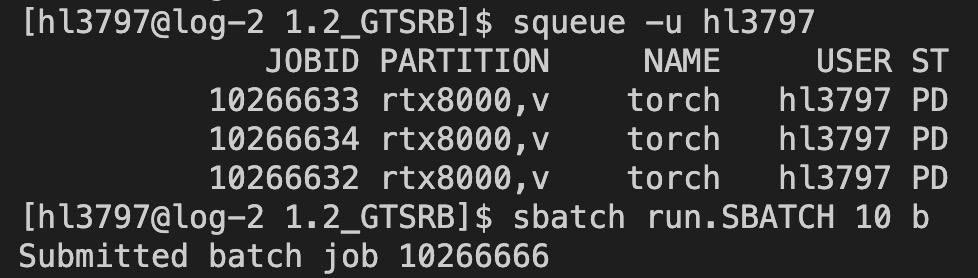

# Submitting to Kaggle

Now take this csv file, download it from your Google drive and then submit it to Kaggle to check performance of your model.

In [ ]:
# Done! Have a good day! :p